In [38]:
# We needed this to prevent the kernel breaks when using matplotlib and pytorch
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [39]:
# import packages

import numpy as np
import math as math
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam
from sklearn.preprocessing import StandardScaler

### Data Preprocessing

Shape of Original output data:  (488, 1269, 1068)


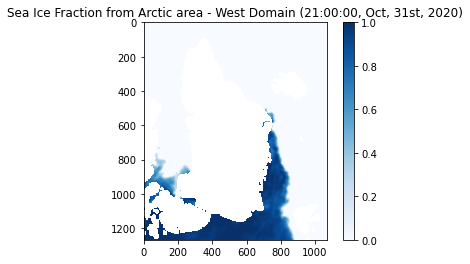

In [40]:
# load and visualize original sea ice proportion
sic_raw = np.load("sic_raw.npy")

# Original output has 1269 by 1069 grid pixels.
print("Shape of Original output data: ", sic_raw.shape)
img = plt.imshow(sic_raw[-1], cmap = 'Blues')
plt.colorbar(img)
plt.title("Sea Ice Fraction from Arctic area - West Domain (21:00:00, Oct, 31st, 2020)")
plt.show()

Shape of reduced output data:  (488, 423, 356)


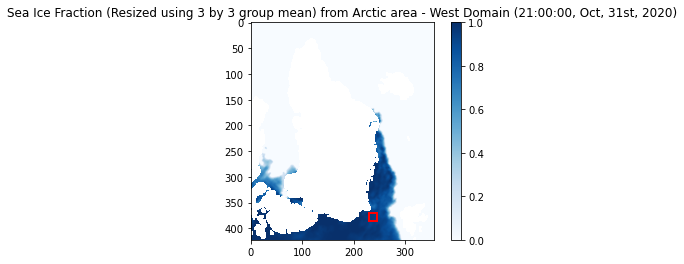

In [41]:
# reducing the size of sea ice proportion image by aggregative the 3 by 3 area average
nsmallr = sic_raw.shape[1]//3
nbigr = sic_raw.shape[1]
nsmallc = sic_raw.shape[2]//3
nbigc = sic_raw.shape[2]
sic_raw = sic_raw[:].reshape([sic_raw.shape[0], nsmallr, nbigr//nsmallr, nsmallc, nbigc//nsmallc]).mean(4).mean(2)
print("Shape of reduced output data: ", sic_raw.shape)

fig, ax = plt.subplots()
img = ax.imshow(sic_raw[-1], cmap = 'Blues')
fig.colorbar(img)

# circle the area that we are going to use for our study to predict sea ice proportion.
rect = patches.Rectangle((230,370), 15, 15, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.title("Sea Ice Fraction (Resized using 3 by 3 group mean) from Arctic area - West Domain (21:00:00, Oct, 31st, 2020)")
plt.show()

Shape of final image output data:  (488, 15, 15)


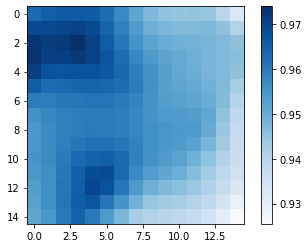

In [42]:
# We still have too many grid pixels. We only choose area with seemingly the most fluctuate in terms of sea ice proportion. 
#  The area is chosen in the red box above.
sic_raw = sic_raw[:, 370:385, 230:245]
print("Shape of final image output data: ", sic_raw.shape)

img = plt.imshow(sic_raw[-1], cmap = 'Blues')
# plt.title("Sea Ice Fraction (Resized using 3 by 3 group mean) from chosen area (21:00:00, Oct, 31st, 2020)")
plt.colorbar(img)
plt.show()

In [43]:
# The original data is more than 10gB. These data were preprocessed and saved bore this analysis.
sic = np.load("sic.npy") # sea ice proportion
si10 = np.load("si10.npy") # wind speed
msl = np.load("msl.npy") # air pressure
sst = np.load("sst.npy") # sea surface temperature
tcc = np.load("tcc.npy") # total cloud cover

In [44]:
# flattening the 2d image to 1d vector for each time step. This is needed to use sea ice proportion data in LSTM for each pixel.
sic_flat = sic.reshape((sic.shape[0], sic.shape[1]*sic.shape[2]))
si10_flat = si10.reshape((si10.shape[0], si10.shape[1]*si10.shape[2]))
msl_flat = msl.reshape((msl.shape[0], msl.shape[1]*msl.shape[2]))
sst_flat = sst.reshape((sst.shape[0], sst.shape[1]*sst.shape[2]))
tcc_flat = tcc.reshape((tcc.shape[0], tcc.shape[1]*tcc.shape[2]))

In [45]:
# We need to reshape the data so that lstm algorithm in pytorch could understand. The input feature should be 3-dimensional.
# This function will group the input and output data by the number of time sequence. In our case, we will only use sequence length of 1.

def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        # Note that we are going to concatenate the above arrays so we will have 5 input features in the end
        _x = time_series[i:i + seq_length, 0:5] # this will group the input data to the number of time sequence.
        _y = time_series[i + seq_length, [-1]] # This will also group the output sea ice proportion to the number of time sequence
                
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)

### LSTM: check the performance using train and test loss

In [46]:
# Define LSTM algorithm

class LSTM1(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): 
        super(LSTM1, self).__init__() 
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first = True) #lstm
        # batch_first is needed to define the order of output shape.
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x): 
        
        out, _status = self.lstm(x)
        out = self.fc(out[:,-1])

        return out

In [47]:
# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 
print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1060


In [48]:
learning_rate = 0.05

num_epochs = 300 # This will be reduced if we find the model gets overfitted
input_size = 5 # 5 input features
hidden_size = 256
num_layers = 2 # stacked LSTM with 2 layers
seq_length = 1 # This can be modified, but we choose 1.

num_classes = 1 # Since we have output of a single variable of sea ice proportion, 1 class is reasonable.

In [49]:
n_train = 400 # Number of training set
n_test = 487-n_train # number of test set
n_pixs = sic_flat.shape[1] # total number of pixels in a time step (n-225)
n_hw = sic.shape[-1] # height and width of the image, 15 by 15

# Since we are predicting sea ice proportion of one time ahead, data from initial time step won't be used as sequence
n_seq = sic.shape[0]-1 # number of sequences. 

In [50]:
# output of predicted value will be saved.
predict_y = []
# the data need to ne scaled. We use the standard scaler in our study.
ss = StandardScaler()

# train and test loss will be saved and presented
train_loss = []
test_loss = []

for i in range(0,(sic_flat.shape[1])): # train for each pixel value
    
    # train and test loss for each pixel will be saved
    train_loss_pix = [] 
    test_loss_pix = []

    # define model (stacked LSTM)
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

    # MSE loss
    loss_function = torch.nn.MSELoss()
    # Adam optimizer
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    # get data for specified pixel, i
    si10_sub = si10_flat[:,i].reshape(si10_flat.shape[0], 1)
    msl_sub = msl_flat[:,i].reshape(msl_flat.shape[0], 1)
    sst_sub = sst_flat[:,i].reshape(sst_flat.shape[0], 1)
    tcc_sub = tcc_flat[:,i].reshape(tcc_flat.shape[0], 1)
    sic_sub = sic_flat[:,i].reshape(sic_flat.shape[0], 1)

    # Scale data with standard scaling (normalize)
    si10_sub_st = ss.fit_transform(si10_sub)
    msl_sub_st = ss.fit_transform(msl_sub)
    sst_sub_st = ss.fit_transform(sst_sub)
    tcc_sub_st = ss.fit_transform(tcc_sub)
    # sic variable should be scaled last as standard scaler need to save the scaling factors of this sic.
    sic_sub_st = ss.fit_transform(sic_sub) # here the last scaling factors will be saved and be used later to denormalize an output.
    
    # data with 5 input features.
    data_all = np.array([si10_sub_st.flatten(), msl_sub_st.flatten(), sst_sub_st.flatten(), 
                         tcc_sub_st.flatten(), sic_sub_st.flatten()]).T
    
    # we will have 400 train sets and 88 test set.
    train_set = data_all[:n_train, :]
    test_set = data_all[n_train:, :]

    # Out of 400 train set, we use 399 for train input for time step 0 to 398. 
    # 399 train output for time step 1 to 399
    X_train, y_train = build_dataset(train_set, seq_length)
    
    # Out of 88 test set, we use 87 for test input for time step 400 to 486tr
    # 87 test output for time step 401 to 487
    X_test, y_test = build_dataset(test_set, seq_length)
    
    # Dataset changed to tensors.
    X_train_tensors = Variable(torch.Tensor(X_train)) 
    print(X_train_tensors.shape)
    X_test_tensors = Variable(torch.Tensor(X_test)) 
    y_train_tensors = Variable(torch.Tensor(y_train)) 
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    # Train model for the number of pixels.
    print("Pixel index is: ", i+1)
    for epoch in range(num_epochs): 
        
        outputs = lstm1.forward(X_train_tensors.to(device))
        optimizer.zero_grad() #  gradients of all optimized to zero
        
        train_loss_pix_dat = loss_function(outputs, y_train_tensors.to(device)) # MSE loss
        train_loss_pix.append(train_loss_pix_dat.item()) # loss for each epoch will be saved
        
        train_loss_pix_dat.backward() # back propagation
        optimizer.step()
        
        pred_out = lstm1.forward(X_test_tensors.to(device)) # do the same for test set
        test_loss_pix_dat = loss_function(pred_out, y_test_tensors.to(device))
        test_loss_pix.append(test_loss_pix_dat.item())
        
        if epoch % 100 == 0: 
            print("Epoch: %d, train loss: %1.5f" % (epoch, train_loss_pix_dat.item()))
            print("Epoch: %d, test loss: %1.5f" % (epoch, test_loss_pix_dat.item()))
    train_loss.append(train_loss_pix)
    test_loss.append(test_loss_pix)
    
    print("\n")

torch.Size([399, 1, 5])
Pixel index is:  1
Epoch: 0, train loss: 1.11921
Epoch: 0, test loss: 0.42220
Epoch: 100, train loss: 0.07200
Epoch: 100, test loss: 0.02957
Epoch: 200, train loss: 0.03271
Epoch: 200, test loss: 0.13708


torch.Size([399, 1, 5])
Pixel index is:  2
Epoch: 0, train loss: 1.09558
Epoch: 0, test loss: 0.33359
Epoch: 100, train loss: 0.06008
Epoch: 100, test loss: 0.01918
Epoch: 200, train loss: 0.02960
Epoch: 200, test loss: 0.08273


torch.Size([399, 1, 5])
Pixel index is:  3
Epoch: 0, train loss: 1.09271
Epoch: 0, test loss: 0.42939
Epoch: 100, train loss: 0.05043
Epoch: 100, test loss: 0.02231
Epoch: 200, train loss: 0.02692
Epoch: 200, test loss: 0.07888


torch.Size([399, 1, 5])
Pixel index is:  4
Epoch: 0, train loss: 1.09786
Epoch: 0, test loss: 0.48455
Epoch: 100, train loss: 0.04854
Epoch: 100, test loss: 0.02224
Epoch: 200, train loss: 0.02039
Epoch: 200, test loss: 0.06262


torch.Size([399, 1, 5])
Pixel index is:  5
Epoch: 0, train loss: 1.10728
Epoch: 

KeyboardInterrupt: 

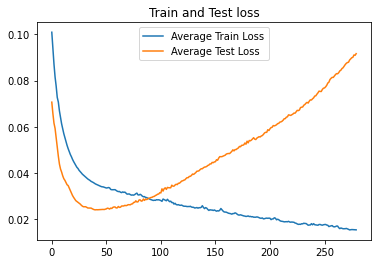

In [15]:
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

# average loss is calculated for all the pixels in each epoch
train_loss_avg = np.mean(train_loss, axis = 0)
test_loss_avg = np.mean(test_loss, axis = 0)

# plot average loss
plt.plot(train_loss_avg[20:], label='Average Train Loss') 
plt.plot(test_loss_avg[20:], label='Average Test Loss') 
plt.title('Train and Test loss')
plt.legend()
plt.show()

### LSTM: Training

In [52]:
# Based on the train and test loss plot above, the number of epochs is chosen as 40 to avoid overfitting.
num_epochs = 40 # epochs

# save training output of LSTM
all_lstm = []

ss = StandardScaler()
for i in range(0,(si10_flat.shape[1])):
    
    # This is the same for above data processing part.
    lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length).to(device)

    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

    si10_sub = si10_flat[:,i].reshape(si10_flat.shape[0], 1)
    print(si10_sub.shape)
    msl_sub = msl_flat[:,i].reshape(msl_flat.shape[0], 1)
    sst_sub = sst_flat[:,i].reshape(sst_flat.shape[0], 1)
    tcc_sub = tcc_flat[:,i].reshape(tcc_flat.shape[0], 1)
    sic_sub = sic_flat[:,i].reshape(sic_flat.shape[0], 1)

    si10_sub_st = ss.fit_transform(si10_sub)
    msl_sub_st = ss.fit_transform(msl_sub)
    sst_sub_st = ss.fit_transform(sst_sub)
    tcc_sub_st = ss.fit_transform(tcc_sub)
    sic_sub_st = ss.fit_transform(sic_sub)
    
    data_all = np.array([si10_sub_st.flatten(), msl_sub_st.flatten(), sst_sub_st.flatten(), 
                         tcc_sub_st.flatten(), sic_sub_st.flatten()]).T
    
    train_set = data_all[:n_train, :]
    test_set = data_all[n_train:, :]

    x, y = build_dataset(data_all, seq_length)

    X_train, y_train = build_dataset(train_set, seq_length)
    X_test, y_test = build_dataset(test_set, seq_length)
    
    X_train_tensors = Variable(torch.Tensor(X_train)) 
    X_test_tensors = Variable(torch.Tensor(X_test)) 
    y_train_tensors = Variable(torch.Tensor(y_train)) 
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    print("Pixel index is: ", i+1)
    for epoch in range(num_epochs): 
        
        outputs = lstm1.forward(X_train_tensors.to(device))
        optimizer.zero_grad() 

        loss = loss_function(outputs, y_train_tensors.to(device)) 

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0: 
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

    sub_lstm = lstm1(Variable(torch.Tensor(x)).to(device)) 
    all_lstm.append(ss.inverse_transform(sub_lstm.data.detach().cpu().numpy())) 
    # both train and test set output was denormalized and saved
    print("\n")

(488, 1)
Pixel index is:  1
Epoch: 0, loss: 1.11217
Epoch: 10, loss: 0.23023
Epoch: 20, loss: 0.12648
Epoch: 30, loss: 0.09746


(488, 1)
Pixel index is:  2
Epoch: 0, loss: 1.09697
Epoch: 10, loss: 0.24081
Epoch: 20, loss: 0.11574
Epoch: 30, loss: 0.08811


(488, 1)
Pixel index is:  3
Epoch: 0, loss: 1.09032
Epoch: 10, loss: 0.38556
Epoch: 20, loss: 0.11074
Epoch: 30, loss: 0.08614


(488, 1)
Pixel index is:  4
Epoch: 0, loss: 1.09589
Epoch: 10, loss: 0.35263
Epoch: 20, loss: 0.11023
Epoch: 30, loss: 0.07276


(488, 1)
Pixel index is:  5
Epoch: 0, loss: 1.10827
Epoch: 10, loss: 0.23539
Epoch: 20, loss: 0.07113
Epoch: 30, loss: 0.05595


(488, 1)
Pixel index is:  6
Epoch: 0, loss: 1.12572
Epoch: 10, loss: 0.23000
Epoch: 20, loss: 0.10270
Epoch: 30, loss: 0.05303


(488, 1)
Pixel index is:  7
Epoch: 0, loss: 1.12859
Epoch: 10, loss: 0.41385
Epoch: 20, loss: 0.12624
Epoch: 30, loss: 0.05044


(488, 1)
Pixel index is:  8
Epoch: 0, loss: 1.14079
Epoch: 10, loss: 0.27632
Epoch: 20, loss: 0.0

KeyboardInterrupt: 

In [17]:
# Both predicted and estimated output was aggregated by the mean of each pixel values
all_lstm = np.array(all_lstm).reshape((n_pixs, n_seq)).T
all_lstm_mean = np.mean(all_lstm, axis = 1)

# True sea ice proportion
sic_true_mean = np.mean(sic_flat[1:,:], axis = 1)

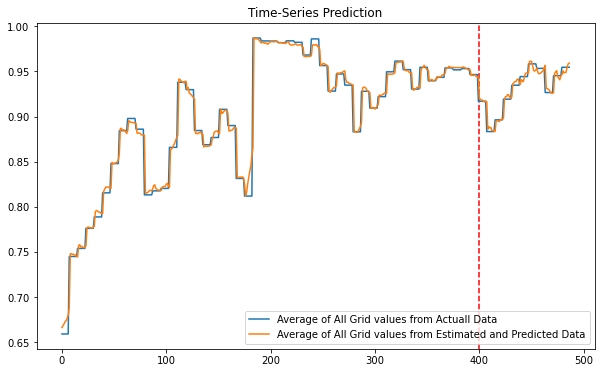

In [18]:
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=n_train, c='r', linestyle='--') #size of the training set

plt.plot(sic_true_mean, label='Average of All Grid values from Actuall Data') #actual plot
plt.plot(all_lstm_mean, label='Average of All Grid values from Estimated and Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

In [19]:
# reshape a vector to 2d images
all_lstm_2d = []
for i in range(n_seq):
    all_lstm_2d.append(all_lstm[i].reshape((n_hw, n_hw)))
all_lstm_2d = np.array(all_lstm_2d)

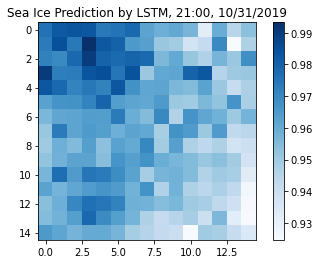

In [20]:
# Predicted sea ice proportion of 21:00:00, Oct, 31st, 2020
lstm_img_dat = all_lstm_2d[-1]
lstm_img = plt.imshow(lstm_img_dat, cmap = 'Blues')
plt.colorbar(lstm_img)
plt.title("Sea Ice Prediction by LSTM, 21:00, 10/31/2019")
plt.show()

### ConvLSTM: Define Model

In [21]:
# Original ConvLSTM cell as proposed by Shi et al.

class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        

        self.conv = nn.Conv2d(
            in_channels = 6, # input channel for CNN should be 6 (1 for hidden state, 5 for input features (X))
            out_channels = 4*out_channels, # 4 output:input gate, output gate, forget gate and cell state
            kernel_size=kernel_size, # filter size
            padding=padding)   

#         We could use multiple layer CNN. We are only using one layer for our study.
#         input channels and output channels need to be modified accordingly.

#         self.conv1 = nn.Conv2d(
#             in_channels = 64*out_channels, 
#             out_channels = 4*out_channels, 
#             kernel_size=kernel_size, 
#             padding=padding)  
        
#         self.conv2 = nn.Conv2d(
#             in_channels = 16*out_channels, 
#             out_channels = 4*out_channels, 
#             kernel_size=kernel_size, 
#             padding=padding)  
        
        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.rand(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.rand(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.rand(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        
#         Again, we are using just one convolutional layer.
#         conv_output1 = self.conv1(conv_output)
#         conv_output2 = self.conv2(conv_output1)
                
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1) # defining input, output, forget gate and cell state
        
        # _conv outputs are convolution of weights and input + weights and hidden state + bias.
        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)
        C = forget_gate*C_prev + input_gate * self.activation(C_conv) # Cell state
        output_gate = torch.sigmoid(o_conv + self.W_co * C)
        
        H = output_gate * self.activation(C) # hidden state

        return H, C

In [22]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        batch_size, _, seq_len, height, width = X.size()

        # initial outputs and Cell and hidden states set to zero.
        # except for height and weight, all the sizes are 1 in our study.
        output = torch.zeros(batch_size, self.out_channels, seq_len, height, width, device=device) 
        
        H = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        C = torch.zeros(batch_size, self.out_channels, height, width, device=device)
        
        # CNN within LSTM runs for each time steps.
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [23]:
# 5 input channels with 5 features,
# 1 output channel with sea ice proportion
# filter size to be 5 and padding set to 2
model = ConvLSTM(in_channels=5, out_channels=1, 
                 kernel_size=(5,5), padding=(2,2), activation="tanh", 
                 frame_size=(15, 15)).to(device)

In [24]:
# SGD optimizer is chosen,
# MSE loss
optim = Adam(model.parameters(), lr=0.1)
loss_function = torch.nn.MSELoss()

### ConvLSTM: Data preprocessing

In [25]:
# Data preprocessing for ConvLSTM
# Since we don't run the model for each pixels independently, we first process data and then run the model.

# Standardize input features.
si10_st = []
sst_st = []
msl_st = []
tcc_st = []
sic_st = []

ss = StandardScaler()
# scalers need to be saaved so that we could use this to denormalize the output data.
scalers = {}
for i in range(sic_flat.shape[0]):
    scalers[i] = StandardScaler()
    si10_sub = ss.fit_transform(si10[i,:,:])
    sst_sub = ss.fit_transform(sst[i,:,:])
    msl_sub = ss.fit_transform(msl[i,:,:])
    tcc_sub = ss.fit_transform(tcc[i,:,:])
    sic_sub = scalers[i].fit_transform(sic[i,:,:]) # save scaling factor

    si10_st.append(si10_sub)
    sst_st.append(sst_sub)
    msl_st.append(msl_sub)
    tcc_st.append(tcc_sub)
    sic_st.append(sic_sub)

si10_st = np.array(si10_st)
sst_st = np.array(sst_st)
msl_st = np.array(msl_st)
tcc_st = np.array(tcc_st)
sic_st = np.array(sic_st)

# defining train and test sets. This is the same for LSTM.
train_set_x = Variable(torch.FloatTensor([np.array([(si10_st[:n_train,:,:]), (msl_st[:n_train,:,:]), 
                                                (sst_st[:n_train,:,:]), (tcc_st[:n_train,:,:]), 
                                                (sic_st[:n_train,:,:])])]))
train_set_y = Variable(torch.FloatTensor(np.array([[(sic_st[1:(n_train+1),:,:])]])))

test_set_x = Variable(torch.FloatTensor([np.array([(si10_st[n_train:n_seq,:,:]), (msl_st[n_train:n_seq,:,:]), 
                                                (sst_st[n_train:n_seq,:,:]), (tcc_st[n_train:n_seq,:,:]), 
                                                (sic_st[n_train:n_seq,:,:])])]))
test_set_y = Variable(torch.FloatTensor(np.array([[(sic_st[(n_train+1):,:,:])]])))

# if we were to interested in predicting without sea ice proportion as input feature, then this sets need to be used for train and test sets
# train_set_x = Variable(torch.FloatTensor([np.array([(si10_st[:n_train,:,:]), (msl_st[:n_train,:,:]), 
#                                                 (sst_st[:n_train,:,:]), (tcc_st[:n_train,:,:])])]))
# test_set_x = Variable(torch.FloatTensor([np.array([(si10_st[n_train:487,:,:]), (msl_st[n_train:487,:,:]), 
#                                                 (sst_st[n_train:487,:,:]), (tcc_st[n_train:487,:,:])])]))

### ConvLSTM: check the performance using train and test loss

In [26]:
num_epochs = 1000 # this is to check the performance of the model. For actual training, we will probabily reduce this.

# Save train and test loss
train_loss = []
test_loss = []

for epoch in range(num_epochs): 
    train_outputs = model.forward(train_set_x.to(device)) # both train set and test set were trained to get the loss.
    test_outputs = model.forward(test_set_x.to(device))
    optim.zero_grad() 
    
    train_loss_dat = loss_function(train_outputs, train_set_y.to(device))
    test_loss_dat = loss_function(test_outputs, test_set_y.to(device))
    
    train_loss.append(train_loss_dat.item()) # both loss are saved
    test_loss.append(test_loss_dat.item())
    train_loss_dat.backward()
    optim.step()
    if epoch % 10 == 0: 
        print("Epoch: %d, Train loss: %1.5f" % (epoch, train_loss_dat.item()))
        print("Epoch: %d, Test loss: %1.5f" % (epoch, test_loss_dat.item()))
        print("\n")

Epoch: 0, Train loss: 1.34374
Epoch: 0, Test loss: 1.30445


Epoch: 10, Train loss: 0.69481
Epoch: 10, Test loss: 0.71031


Epoch: 20, Train loss: 0.66168
Epoch: 20, Test loss: 0.68148


Epoch: 30, Train loss: 0.64219
Epoch: 30, Test loss: 0.65946


Epoch: 40, Train loss: 0.62929
Epoch: 40, Test loss: 0.64992


Epoch: 50, Train loss: 0.62278
Epoch: 50, Test loss: 0.64664


Epoch: 60, Train loss: 0.62414
Epoch: 60, Test loss: 0.64326


Epoch: 70, Train loss: 0.61647
Epoch: 70, Test loss: 0.63975


Epoch: 80, Train loss: 0.60981
Epoch: 80, Test loss: 0.63824


Epoch: 90, Train loss: 0.60492
Epoch: 90, Test loss: 0.63700


Epoch: 100, Train loss: 0.60204
Epoch: 100, Test loss: 0.63575


Epoch: 110, Train loss: 0.60113
Epoch: 110, Test loss: 0.63687


Epoch: 120, Train loss: 0.59910
Epoch: 120, Test loss: 0.63962


Epoch: 130, Train loss: 0.59712
Epoch: 130, Test loss: 0.63404


Epoch: 140, Train loss: 0.59542
Epoch: 140, Test loss: 0.62887


Epoch: 150, Train loss: 0.59261
Epoch: 150, Tes

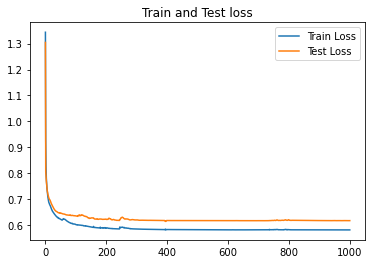

In [27]:
# train and test loss are presented
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)

plt.plot(train_loss, label='Train Loss') 
plt.plot(test_loss, label='Test Loss') 
plt.title('Train and Test loss')
plt.legend()
plt.show()

### ConvLSTM: Training

In [28]:
model = ConvLSTM(in_channels=5, out_channels=1, 
                 kernel_size=(5,5), padding=(2,2), activation="tanh", 
                 frame_size=(15, 15)).to(device)

optim = SGD(model.parameters(), lr=0.1)
loss_function = torch.nn.MSELoss()

# number of epochs are reduced to 500 for efficiency.
# train ConvLSTM
num_epochs = 500
for epoch in range(num_epochs): 
    outputs = model.forward(train_set_x.to(device))
    optim.zero_grad()
    loss_convlstm = loss_function(outputs, train_set_y.to(device))
    loss_convlstm.backward() 
    optim.step() 
    if epoch % 10 == 0: 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss_convlstm.item()))

Epoch: 0, loss: 0.95693
Epoch: 10, loss: 0.58182
Epoch: 20, loss: 0.53040
Epoch: 30, loss: 0.48829
Epoch: 40, loss: 0.45549
Epoch: 50, loss: 0.42911
Epoch: 60, loss: 0.41283
Epoch: 70, loss: 0.39159
Epoch: 80, loss: 0.37602
Epoch: 90, loss: 0.36583
Epoch: 100, loss: 0.35053
Epoch: 110, loss: 0.33944
Epoch: 120, loss: 0.32950
Epoch: 130, loss: 0.32238
Epoch: 140, loss: 0.31455
Epoch: 150, loss: 0.30437
Epoch: 160, loss: 0.29465
Epoch: 170, loss: 0.29943
Epoch: 180, loss: 0.30569
Epoch: 190, loss: 0.28389
Epoch: 200, loss: 0.27818
Epoch: 210, loss: 0.27347
Epoch: 220, loss: 0.26920
Epoch: 230, loss: 0.26406
Epoch: 240, loss: 0.32076
Epoch: 250, loss: 0.26013
Epoch: 260, loss: 0.25481
Epoch: 270, loss: 0.24927
Epoch: 280, loss: 0.24982
Epoch: 290, loss: 0.25507
Epoch: 300, loss: 0.24371
Epoch: 310, loss: 0.25721
Epoch: 320, loss: 0.24163
Epoch: 330, loss: 0.23733
Epoch: 340, loss: 0.23634
Epoch: 350, loss: 0.23559
Epoch: 360, loss: 0.23197
Epoch: 370, loss: 0.23540
Epoch: 380, loss: 0.236

In [29]:
estimate_clstm = model(train_set_x.to(device))#forward pass
predict_clstm = model(test_set_x.to(device))#forward pass

all_clstm_2d = []
for i in range(n_train):
    all_clstm_2d.append(scalers[i+1].inverse_transform(estimate_clstm[0,0,i,:,:].data.detach().cpu().numpy()))
for i in range(n_test):
    all_clstm_2d.append(scalers[n_train+1+i].inverse_transform(predict_clstm[0,0,i,:,:].data.detach().cpu().numpy()))

all_clstm_2d = np.array(all_clstm_2d)
all_clstm = all_clstm_2d.reshape((n_seq, n_pixs))
all_clstm_mean = np.mean(all_clstm, axis = 1)

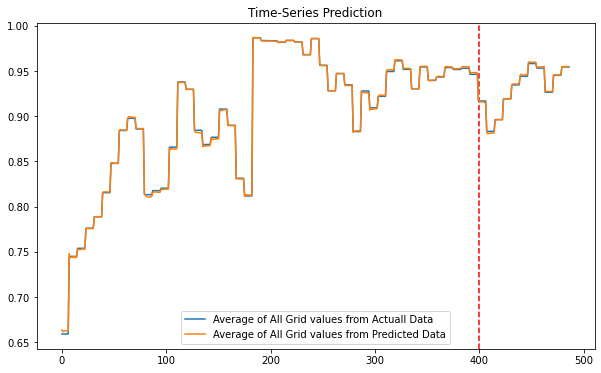

In [30]:
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=400, c='r', linestyle='--') #size of the training set

plt.plot(sic_true_mean, label='Average of All Grid values from Actuall Data') #actual plot
plt.plot(all_clstm_mean, label='Average of All Grid values from Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

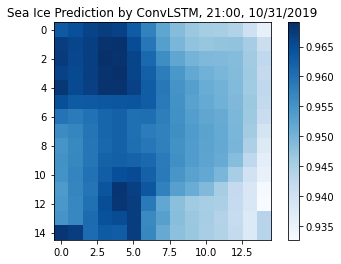

In [31]:
clstm_img_dat = plt.imshow(all_clstm_2d[-1], cmap = 'Blues')
plt.title("Sea Ice Prediction by ConvLSTM, 21:00, 10/31/2019")
plt.colorbar(clstm_img_dat)
plt.show()

### Model evlauation: Root Mean Squared Erorr, Correlation Coefficient, Mean Difference

In [32]:
# Calculate rmse for each sequence.
rmse_lstm = []
rmse_clstm = []
for i in range(n_seq):
    rmse_lstm.append(np.sqrt(np.mean((sic_flat[i+1] - all_lstm[i])**2)))
for i in range(n_seq):
    rmse_clstm.append(np.sqrt(np.mean((sic_flat[i+1] - all_clstm[i])**2)))

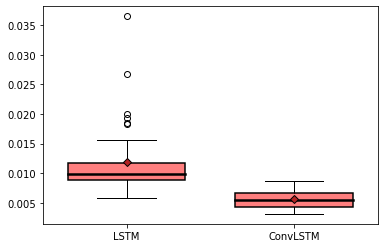

In [33]:
#  plotting rmse for prediction value from testing set
fig, ax = plt.subplots()
mprop = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
medprop = dict(linestyle='-', linewidth=2.5, color='black')
boxprop = dict(linestyle='-', linewidth=1.5, facecolor=(1,0,0,.5))
                
bp1 = ax.boxplot(rmse_lstm[450:], positions=[1], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
bp2 = ax.boxplot(rmse_clstm[450:], positions=[2], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
ax.set_xlim(0.5,2.5)
plt.xticks([1, 2], ['LSTM', 'ConvLSTM'])
plt.show()

In [34]:
# Calculate correlation coefficient for each sequence.
corr_lstm = []
for i in range(n_seq):
    corr_lstm.append(np.corrcoef(sic_flat[i+1], all_lstm[i])[0,1])
corr_clstm = []
for i in range(n_seq):
    corr_clstm.append(np.corrcoef(sic_flat[i+1], all_clstm[i])[0,1])

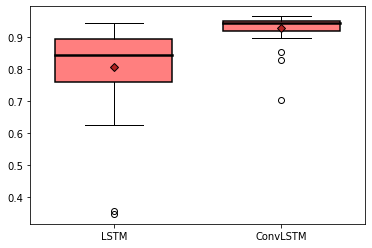

In [35]:
#  plotting correlation coefficient  for prediction value from testing set
fig, ax = plt.subplots()
bp1 = ax.boxplot(corr_lstm[450:], positions=[1], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
bp2 = ax.boxplot(corr_clstm[450:], positions=[2], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
ax.set_xlim(0.5,2.5)
plt.xticks([1, 2], ['LSTM', 'ConvLSTM'])
plt.show()

In [36]:
# Calculate correlation mean differnece for each sequence.
md_lstm = []
md_clstm = []
for i in range(n_seq):
    md_lstm.append(np.mean(sic_flat[i+1] - all_lstm[i]))
for i in range(n_seq):
    md_clstm.append(np.mean(sic_flat[i+1] - all_clstm[i]))

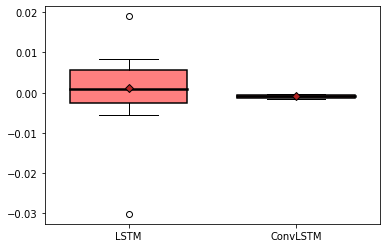

In [37]:
#  plotting mean difference  for prediction value from testing set
fig, ax = plt.subplots()
bp1 = ax.boxplot(md_lstm[450:], positions=[1], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
bp2 = ax.boxplot(md_clstm[450:], positions=[2], widths=0.7, patch_artist=True, meanprops = mprop, 
                 medianprops=medprop, boxprops=boxprop, showmeans=True)
ax.set_xlim(0.5,2.5)
plt.xticks([1, 2], ['LSTM', 'ConvLSTM'])
plt.show()